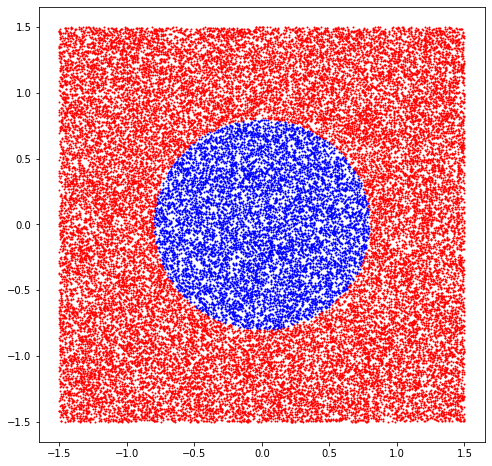

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.callbacks import TensorBoard
%matplotlib inline

N=40000
K=3
X = K*np.random.rand(N,2) 
X[:,0] = X[:,0]-K/2
X[:,1] = X[:,1]-K/2

Y = np.zeros([N,2])

for i in range(N):
    if (X[i,0])**2+(X[i,1])**2<0.64:
        Y[i,0]=1
    else:
        Y[i,1]=1

zero_class = np.where(Y[:, 0])
one_class = np.where(Y[:, 1])

plt.figure(figsize=(8, 8))
plt.scatter(X[zero_class, 0], X[zero_class, 1], s=1, facecolors='b', linewidths=1, label='Class 1')
plt.scatter(X[one_class, 0], X[one_class, 1], s=1, facecolors='r', linewidths=1, label='Class 2')
plt.show()

data = X
labels = Y

In [63]:
num_hid1 = 2
num_hid2 = 10
model = tf.keras.Sequential()
# Adds a densely-connected layer with 64 units to the model:
model.add(Dense(num_hid1, input_shape=(2,), activation='relu'))
# Add another:
model.add(Dense(num_hid2, activation='relu'))
# Add a softmax layer with 10 output units:
model.add(Dense(2, activation='softmax'))

# Configure a model for categorical classification.
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=[tf.keras.metrics.categorical_accuracy])

tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0,
                          write_graph=True, write_images=False)

model_name = str(num_hid1)+'_'+str(num_hid2)+'_'+'2'

import os
directory = 'model_'+model_name
if not os.path.exists(directory):
    os.makedirs(directory)
    
model.save(directory+'/'+model_name+'_model.h5') 

In [64]:
from tensorflow.keras import backend as K
#Return the activation matrix of a given input data to a model
get_second_layer_output = K.function(model.layers[0].input,model.layers[0].output)
get_third_layer_output = K.function(model.layers[0].input,model.layers[1].output)

def get_act_mat(data): 
    if num_hid2 != 0:
        [second_layer_output] = get_second_layer_output(data.reshape(1,2))
        [third_layer_output] = get_third_layer_output(data.reshape(1,2))

        second_layer_nonzero_index = np.flatnonzero(second_layer_output)
        third_layer_nonzero_index = np.flatnonzero(third_layer_output)
        second_layer_output[second_layer_nonzero_index] = 1
        third_layer_output[third_layer_nonzero_index] = 1

        act_mat = [second_layer_output, third_layer_output]
    else:
        [second_layer_output] = get_second_layer_output(data.reshape(1,2))
        second_layer_nonzero_index = np.flatnonzero(second_layer_output)
        second_layer_output[second_layer_nonzero_index] = 1
        act_mat = second_layer_output
    return act_mat

def get_act_matrix(hid1, hid2):
    if num_hid2 != 0:
        matrix = []
        for i in range(2**hid1):
            first_layer_act = np.asarray([int(x) for x in list(('{:0'+str(hid1)+'b}').format(i))])
            for j in range(2**hid2):
                second_layer_act = np.asarray([int(x) for x in list(('{:0'+str(hid2)+'b}').format(j))])
                matrix.append([first_layer_act, second_layer_act])
    else:
        matrix = []
        for i in range(2**hid1):
            first_layer_act = np.asarray([int(x) for x in list(('{:0'+str(hid1)+'b}').format(i))])
            matrix.append(first_layer_act)           
    return matrix  

activation_matrix = get_act_matrix(num_hid1,num_hid2)

def assign_color(activation_matrix,activations,act_index):
    if num_hid2 != 0:
        for index in range(len(activation_matrix)):
            if (activation_matrix[index][0] == activations[act_index][0]).all() and (activation_matrix[index][1] == activations[act_index][1]).all():
                return index
    else:
        for index in range(len(activation_matrix)):
            if (activation_matrix[index] == activations[act_index]).all():
                return index
    
R = range(0,255,13)
G = range(0,255,13)
B = range(0,255,13)
rv,gv,bv = np.meshgrid(R,G,B)
colors = np.array([rv.flatten(),gv.flatten(),bv.flatten()]).transpose()

In [ ]:
import multiprocessing
from multiprocessing import Pool
from functools import partial

Grid = 200
k = 2
x = np.linspace(-k,k,Grid+1)
y = np.linspace(-k,k,Grid+1) 

xv,yv = np.meshgrid( x , y )
X_test = np.array([xv.flatten(),yv.flatten()])
X_test = X_test.transpose()
 
num_epoch = 10
pool = Pool(8)
for i in range(num_epoch):
    print("epoch:{0}".format(i), end="\n")
    #loop for all data points to get activations
    i_data = 0
    activations = []

    for test_data in X_test:
        print("get activation progress:{0}%".format(round((i_data + 1) * 100 / len(X_test))), end='\r')
        activations.append(get_act_mat(test_data))
        i_data = i_data + 1
    print(end="\n")
    
    f = partial(assign_color, activation_matrix, activations)
    
    i_color=0
    data_activation_color=[]
    for y in pool.map(f, range(len(activations))):
        i_color+=1
        print("get data color progress:{0}%".format(round((i_color + 1) * 100 / len(activations))), end="\r")
        data_activation_color.append(y)
    print(end="\n")
    
    data_activation_color = np.asarray(data_activation_color)
    act_clusters = np.unique(data_activation_color)
    cluster_index = []
    for j in range(len(act_clusters)):
        cluster_index.append(np.where(data_activation_color == act_clusters[j]))
        
    progress = 0
    plt.figure(figsize=(8, 8))
    for k in range(len(cluster_index)):
        progress += 1
        #print("Progress:{0}%".format(round((progress + 1) * 100 / len(cluster_index))), end="\r")
        plt.scatter(X_test[cluster_index[k], 0], X_test[cluster_index[k], 1], marker='o',s=4, color=colors[data_activation_color[cluster_index[k]][0]]/255.0, linewidths=2)
    #print(end="\n")
    
    #plt.show()
    plt.savefig(directory+'/'+'epoch'+str(i)+'_'+model_name+'_activation')
    
    Y_test = model.predict(X_test)
    Y_test = np.rint(Y_test)
    zero_class_test = np.where(Y_test[:, 0])
    one_class_test = np.where(Y_test[:, 1])

    plt.figure(figsize=(8, 8))
    plt.scatter(X_test[zero_class_test, 0], X_test[zero_class_test, 1], marker='o',s=3, facecolors='r', linewidths=1, label='Class 1')
    plt.scatter(X_test[one_class_test, 0], X_test[one_class_test, 1], marker='o', s=1, facecolors='b', linewidths=1, label='Class 2')
    plt.savefig(directory+'/'+'epoch'+str(i)+'_'+model_name+'_decisionboundary')
    model.fit(data, labels, epochs=1,batch_size=int(N/400),callbacks=[tensorboard])
    plt.close()
    
pool.close()
pool.join()

epoch:0
get activation progress:100%
get data color progress:100%
Train on 40000 samples
40000/40000 [==============================] - 1s 21us/sample - loss: 0.4970 - categorical_accuracy: 0.7713
epoch:1
get activation progress:100%
get data color progress:100%
Train on 40000 samples
40000/40000 [==============================] - 1s 20us/sample - loss: 0.4116 - categorical_accuracy: 0.7767
epoch:2
get activation progress:100%
get data color progress:100%
Train on 40000 samples
40000/40000 [==============================] - 1s 18us/sample - loss: 0.3874 - categorical_accuracy: 0.7767
epoch:3
get activation progress:100%
get data color progress:100%
Train on 40000 samples
40000/40000 [==============================] - 1s 19us/sample - loss: 0.3798 - categorical_accuracy: 0.7767
epoch:4
get activation progress:100%
get data color progress:100%
Train on 40000 samples
40000/40000 [==============================] - 1s 18us/sample - loss: 0.3764 - categorical_accuracy: 0.7767
epoch:5
get act

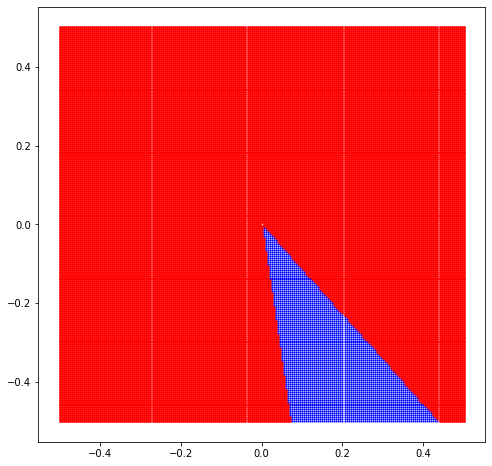

In [17]:
#test
import numpy as np
Grid = 200
k = 0.5
x = np.linspace(-k,k,Grid+1)
y = np.linspace(-k,k,Grid+1) 

xv,yv = np.meshgrid( x , y )
X_test = np.array([xv.flatten(),yv.flatten()])
X_test = X_test.transpose()
#np.random.shuffle(X_test)

Y_test = model.predict(X_test)
Y_test = np.rint(Y_test)

zero_class_test = np.where(Y_test[:, 0])
one_class_test = np.where(Y_test[:, 1])

plt.figure(figsize=(8, 8))
plt.scatter(X_test[zero_class_test, 0], X_test[zero_class_test, 1], marker='o',s=3, facecolors='r', linewidths=1, label='Class 1')
plt.scatter(X_test[one_class_test, 0], X_test[one_class_test, 1], marker='o', s=1, facecolors='b', linewidths=1, label='Class 2')
plt.show()
plt.savefig(directory+'/'+'test')
plt.close()

In [12]:
num_hid1 = 12
num_hid2 = 0
model = tf.keras.Sequential()
# Adds a densely-connected layer with 64 units to the model:
model.add(Dense(num_hid1, input_shape=(2,), activation='relu'))
# Add another:
#model.add(Dense(num_hid2, activation='relu'))
# Add a softmax layer with 10 output units:
model.add(Dense(2, activation='softmax'))

# Configure a model for categorical classification.
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=[tf.keras.metrics.categorical_accuracy])

tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0,
                          write_graph=True, write_images=False)

In [ ]:
import multiprocessing
from multiprocessing import Pool
from functools import partial
import pdb

Grid = 200
k = 0.5
x = np.linspace(-k,k,Grid+1)
y = np.linspace(-k,k,Grid+1) 

xv,yv = np.meshgrid( x , y )
X_test = np.array([xv.flatten(),yv.flatten()])
X_test = X_test.transpose()


#loop for all data points to get activations
i_data = 0
activations = []

for test_data in X_test:
    print("get activation progress:{0}%".format(round((i_data + 1) * 100 / len(X_test))), end="\r")
    activations.append(get_act_mat(test_data))
    i_data = i_data + 1
print(end="\n")

f = partial(assign_color,activation_matrix,activations)

i_color=0
data_activation_color=[]

pool = Pool(4)
for y in pool.map(f, range(len(activations))):
    i_color+=1
    print("get data color progress:{0}%".format(round((i_color + 1) * 100 / len(activations))), end="\r")
    data_activation_color.append(y)
print(end="\n")
# for y in range(len(activations)):
#     i_color+=1
#     print("get data color progress:{0}%".format(round((i_color + 1) * 100 / len(activations))), end="\r")
#     data_activation_color.append(f(y))
# print(end="\n")

data_activation_color = np.asarray(data_activation_color)
act_clusters = np.unique(data_activation_color)
cluster_index = []
for j in range(len(act_clusters)):
    cluster_index.append(np.where(data_activation_color == act_clusters[j]))

pool.close()
pool.join()

get activation progress:100%


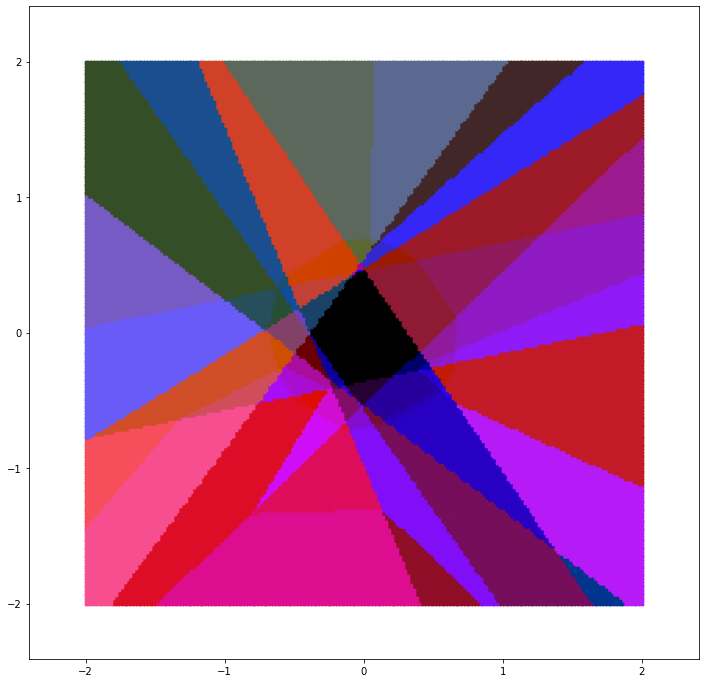

<Figure size 432x288 with 0 Axes>

In [47]:
progress = 0
plt.figure(figsize=(12, 12))
for k in range(len(cluster_index)):
    progress += 1
    #print("Progress:{0}%".format(round((progress + 1) * 100 / len(cluster_index))), end="\r")
    plt.scatter(X_test[cluster_index[k], 0], X_test[cluster_index[k], 1], marker='o',s=4, color=colors[data_activation_color[cluster_index[k]][0]]/255.0, linewidths=2)
plt.margins(x=0.1, y=0.1)
plt.show()
plt.savefig('activation')

In [25]:
act_clusters

array([   0,    1,    4,    8,   16,   32,   36,   64,   72,  128,  129,
        256,  257,  260,  292,  512,  576,  584, 1024, 1040, 1056, 1072,
       2048, 2056, 2064, 3088])

In [27]:
data_activation_color

array([None, None, None, ..., None, None, None], dtype=object)